## Install packages

In [1]:
# !pip3 install --user pandas
# !pip3 install --user numpy
# !pip3 install --user joblib
# !pip3 install --user scipy

## Import librairies and functions

In [88]:
import joblib
import os
import pandas as pd
import numpy as np
from scipy import interpolate
import pandas as pd
from typing import Dict, List
import matplotlib.pyplot as pyplot
%matplotlib inline 

def load(directory: str, filename: str) -> pd.DataFrame:
    """
    Load a dataframe from pickle format.
    """
    path = os.path.join(directory, filename)
    df = joblib.load(path)
    return df

def load_numpy(directory: str, filename: str) -> np.array:
    """
    Load a dataframe from pickle format.
    """
    path = os.path.join(directory, filename)
    np_array = joblib.load(path)
    return np_array

def save(df: pd.DataFrame, directory: str, filename: str) -> pd.DataFrame:
    """
    Save a dataframe into pickle format.
    """
    path = os.path.join(directory, filename)
    joblib.dump(df, path)

    

def save_numpy(df: pd.DataFrame, directory: str, filename: str) -> pd.DataFrame:
    """
    convert a dataframe into numpy and save into pickle format.
    """
    path = os.path.join(directory, filename)
    joblib.dump(df.to_numpy(), path)

def clean_batch_of_raw_data_time_windowed(
    df: pd.DataFrame,
    time_window: float,
    means,
    stds
) -> pd.DataFrame:
    """
    Clean a batch of raw data.

    Parameters
    ----------
    df : pd.DataFrame
        A batch of raw messages.

    Returns
    -------
    pd.DataFrame
        Batch of clean data
    """
    df = convert_objects_to_float(df)
    df = add_NSG_columns_and_sort_columns_alphabetically(df)
    df = angle_transform(df)
    df = remove_disturbance(df)
    df = keep_fixed_time_data(df, time_window)
    df = interpolation_reconstruction_delta_T(df, 0.01)
    df = normalise_df(df, means, stds)
#     df = df.droplevel(1, axis=1) # removed by amar
    return df



def load_clean_save_data_numpy_by_batch(
    root_dir: str,
    output_data_dir: str,
    sep: str,
    header: List[int],
    time_window: float,
    means,
    stds
) -> np.array:
    """
    Load, clean and save raw data batch by batch.

    Parameters
    ----------
    root_dir : str
        Directory to probe for loading.
    output_data_dir : str
        Directory where to save cleaned data.
    sep : str
        Separator used when reading CSVs.
    cols_to_keep : List[str]
        List of columns to keep. All other columns are dropped.
    """
    for i, file in enumerate(os.listdir(root_dir)):
#         if i > 40:
#             break
        if file.endswith('results_cascs.csv'):
            continue
        else:
            if i%20 ==0: 
                print(i, file) # give multiples of 2 here
            file_path = os.path.join(root_dir, file)
            df = pd.read_csv(file_path, sep=',', header=[0,1])
            try:
                df = clean_batch_of_raw_data_time_windowed(df, time_window, means, stds)
                save_numpy(df, output_data_dir, file.split("_")[0]+'.pkl')
                if i% 20 ==0: 
                    print(i, output_data_dir, '/' , file.split("_")[0]+'.pkl' )  # give multiples of 2 here
            except:
                print("----- Error in processing ", file, " --- Mostly due to cascading failure ")
            



def load_clean_save_raw_data_by_batch(
    root_dir: str,
    output_data_dir: str,
    sep: str,
    header: List[int],
    time_window: float,
    means,
    stds
) -> pd.DataFrame:
    """
    Load, clean and save raw data batch by batch.

    Parameters
    ----------
    root_dir : str
        Directory to probe for loading.
    output_data_dir : str
        Directory where to save cleaned data.
    sep : str
        Separator used when reading CSVs.
    cols_to_keep : List[str]
        List of columns to keep. All other columns are dropped.
    """
    for i, file in enumerate(os.listdir(root_dir)):
        if i > 10:
            break
        if file.endswith('results_cascs.csv'):
            continue
        else:
            print(i, file)
            file_path = os.path.join(root_dir, file)
            df = pd.read_csv(file_path, sep=',', header=[0,1])
            try:
                df = clean_batch_of_raw_data_time_windowed(df, time_window, means, stds)
                save(df, output_data_dir, file.replace('.csv', '.pkl'))
            except:
                print("----- Error in processing ", file, " --- Mostly due to cascading failure ")
            

def get_list_simulations(root_dir: str) -> List[str]:
    """
    Get a list with all the name of the simulation csv files.
    """
    file_list_simulations = []
    for i, file in enumerate(os.listdir(root_dir)):
        if file.endswith('results_cascs.csv'):
            continue
        else:
            file_list_simulations.append(file)
    return file_list_simulations


def get_dict_scenario_csv(file_list_simulations: List[str]) -> Dict[int, str]:
    """
    Build dictionary of scenario number and the corresponding name of the csv file
    with simulation data.
    """
    simulation_files_dict = {}
    for file_name in file_list_simulations:
        simulation_files_dict[int(file_name.split("_")[0])] = file_name
    return simulation_files_dict


def add_NSG_columns_and_sort_columns_alphabetically(
    df: pd.DataFrame
) -> pd.DataFrame:
    """
    Add NSG columns when missing from dataframe in order
    to get homogeneous set of columns in each dataframe.
    """
    cols_to_add = [('NSG_1', 'Active Power in MW'), ('NSG_1', 'Reactive Power in Mvar' ), ('NSG_2', 'Active Power in MW'), ('NSG_3', 'Active Power in MW')]
    for col in cols_to_add:
        if not col in df.columns:
            df[col] = '0'
    df = df.sort_index(axis=1)
    return df


def convert_objects_to_float(df: pd.DataFrame) -> pd.DataFrame:
    """
    Convert columns with object dtype to floats in order to use them in models.
    """
    indicator = df.dtypes == 'object'
    categorical_columns = df.columns[indicator].tolist()
    for col in categorical_columns:
        df[col] = df[col].astype('float')
    return df


def interpolation_reconstruction_delta_T(df: pd.DataFrame, delta_T: float = 0.01) -> pd.DataFrame:
    """
    Compute interpolated timestamp for each scenario.
    The interpolation is made on a regular grid of x-values spanning the same interval as during the simulatio with a delta_T specified by user.
    IMPORTANT - ASSUMES time.min() < 1.08
    
    Parameters
    ----------
    df : pd.DataFrame
        Simulation dataframe
    delta_T : float
        The time difference between consecutive data.
    """
    list_concat = []
    for col in df.columns[1:]:
        X = df['All calculations', 'Time in s'].values
        y = df[col].values
        f = interpolate.interp1d(X, y, kind='slinear')
        xgrid = np.arange(1.08, X.max(), delta_T)
        ygrid = f(xgrid)
        to_concat = pd.DataFrame(
            {('All calculations', 'Time in s'): xgrid, col: ygrid})
        list_concat.append(to_concat)
    dfs = [df.set_index(('All calculations', 'Time in s'))
           for df in list_concat]
    interpolate_construction = pd.concat(dfs, axis=1)
    return interpolate_construction.reset_index()


def pre_normalisation_mean_and_std(df):
    """
    find mean and std of a given df for
    normalisation purposes

    """
    x = df.values.astype(float)
    mean = x.mean(axis=0)
    std = x.std(axis=0)
    return mean, std


def pre_scaling(df):
    """
    find scalling of a given df for
    normalisation purposes. Returning a mean and std to match output of 'pre_normalisation_mean_and_std'
    The mean in this case is 0 and the std is the scaling

    """
    df[df.filter(regex='p.u.').columns] = 1.0 # replacing values of the columns in p.u. with 1
    df[df.filter(regex='MW').columns] = 100.0 # replacing values of the columns in MW with 100
    df[df.filter(regex='Mvar').columns] = 100.0 # replacing values of the columns in Mvar with 100
    df[df.filter(regex='kA').columns] = 100.0 # replacing values of the columns in kA with 100
    x = df.values.astype(float)
    std = np.abs(x).max(axis=0)
    mean = np.zeros(std.shape)
    return mean, std
    

def find_means_and_stds(sample_size, root_dir, simulation_files_dict, time_window):
    """
    find the average mean and std of each column from
    a sample of size sample_size
    run this before running clean_batch_of_raw_data()

    """
    means = []
    stds = []
    random_chosen_files = np.random.choice(44000, sample_size, replace = False) # Amar - choosing randomly to avoid bias
    samples = 0
    for i in range(sample_size):
        df = pd.read_csv(os.path.join(root_dir,
                                    simulation_files_dict[random_chosen_files[i]]), sep=',', header=[0, 1])
        df = convert_objects_to_float(df)
        df = add_NSG_columns_and_sort_columns_alphabetically(df)
        df = angle_transform(df)
        df = remove_disturbance(df)
        n_cols = df.shape[1]
#         df = keep_fixed_time_data(df, time_window)
#         df = interpolation_reconstruction_delta_T(df, delta_T=0.01)
#         mean, std = pre_normalisation_mean_and_std(df) # commented by Amar
        try:
            mean, std = pre_scaling(df)
            means.append(mean)
            stds.append(std)
            samples = samples+1
        except:
            pass
    print("Final sample size is ", samples)
    return np.concatenate((means)).reshape(samples, n_cols).mean(axis=0).reshape(1, n_cols), np.concatenate((stds)).reshape(samples, n_cols).max(axis=0).reshape(1, n_cols) # changed by Amar to 'max' from 'mean'


def normalise_df(df, means, stds):
    """
    normalise a single dataframe column by column
    it is probably possible to vectorise this and make it faster...
    means and stds can either be saved to the workspace or can
    change clean_batch_of_raw_data() to take them as inputs

    """
    n_cols = df.shape[1]
    for i in range(1, n_cols):
        df.iloc[:, i] = df.iloc[:, i].astype(float) - means[0][i]
        if stds[0][i] == 0:  # some variables may return zero st. dev. for certain batches
            continue
        else:
            df.iloc[:, i] = df.iloc[:, i].astype(float)/stds[0][i]
    return df


def remove_disturbance(df: pd.DataFrame) -> pd.DataFrame:
    """
    Remove all data before the disturbance happens,
    it is said to happen at 1.075s
    """
    where = df['All calculations', 'Time in s'].astype(float) > 1.075
    return df[where]


def angle_transform(df):

    """
    Transform angle data: theta -> (sin(theta), cos(theta))
    creates two new columns and removes the angle column
    note that this adds 10 new columns to the dataframe
    """

    generators = ["G 01", "G 02", "G 03", "G 04", "G 05", "G 06", "G 07", "G 08", "G 09", "G 10"]

    for gen in generators:
        sinangle = np.sin((np.pi/180)*df.loc[:, (gen, "Rotor angle with reference to reference machine angle in deg")])
        cosangle = np.cos((np.pi/180)*df.loc[:, (gen, "Rotor angle with reference to reference machine angle in deg")])
        columns = df.columns
        sinangleind = columns.get_loc((gen, "Rotor angle with reference to reference machine angle in deg"))
        df = df.drop((gen, "Rotor angle with reference to reference machine angle in deg"), axis = 1)
        df.insert(sinangleind, (gen, "sin of rotor angle"), sinangle)
        df.insert(sinangleind+1, (gen, "cos of rotor angle"), cosangle)
    return df


def remove_disturbance(df: pd.DataFrame) -> pd.DataFrame:
    """
    Remove all data before the disturbance happens,
    it is said to happen at 1.075s
    """
    where = df['All calculations', 'Time in s'].astype(float) > 1.075
    return df[where]


def remove_pre_cascade_data(df: pd.DataFrame, time_cutoff: float = 0.5) -> pd.DataFrame:
    """
    Remove all data just before cascading occurs. The 'time_cutoff' gives the time before the cascade that we stop the data  
    """
    X = df['All calculations', 'Time in s'].values
    where = df['All calculations', 'Time in s'].astype(float) < X.max() - time_cutoff
    return df[where]


def keep_fixed_time_data(df: pd.DataFrame, time_window: float = 1.3) -> pd.DataFrame:
    """
    Keep only data in a small time_window after the start of the data-set. The 'time_window' gives the time for which we will retain the data  
    """
    X = df['All calculations', 'Time in s'].values
    where = df['All calculations', 'Time in s'].astype(float) < X.min() + time_window
    return df[where]

### Get dictionnary

In [3]:
root_dir = '/data/Data'

file_list_simulations= get_list_simulations(root_dir)
simulation_files_dict = get_dict_scenario_csv(file_list_simulations)

In [4]:
len(simulation_files_dict.keys())

44064

### Gets lists for normalization

In [82]:
means, stds = find_means_and_stds(30, root_dir, simulation_files_dict, time_window = 10.0) # means are all zero. stds is the max value
# stds[0][0] = 1 # std of time = 1
joblib.dump(stds,"scaling.pkl")

Final sample size is  30


['scaling.pkl']

In [87]:
print(stds)

[[120.           1.           1.           1.           1.
    1.           1.           1.           1.           1.
    1.           1.           1.           1.           1.
    1.           1.           1.           1.           1.
    1.           1.           1.           1.           1.
    1.           1.           1.           1.           1.
    1.           1.           1.           1.           1.
    1.           1.           1.           1.           1.
    1.           1.           1.           1.           1.
    1.           1.           1.           1.           1.
    1.           1.           1.           1.           1.
    1.           1.           1.           1.           1.
    1.           1.           1.           1.           1.
    1.           1.           1.           1.           1.
    1.           1.           1.           1.           1.
    1.           1.           1.         100.         100.
    0.99999995   0.99999999   1.           1.         10

## Launch preprocessing pipeline

In [0]:
os.makedirs(os.path.join('/output/', '02_preprocessed_numpy'), exist_ok=True)

In [89]:
load_clean_save_data_numpy_by_batch(
    root_dir='/data/Data',
    output_data_dir='/output/02_preprocessed_numpy',
    sep=',',
    header=[0,1],
    time_window=10.0,
    means=means,
    stds=stds
)

0 10000_Line 10 - 11_load=0.8_wind=0.4_0.2_0.csv


0 /output/02_preprocessed_numpy / 10000.pkl


20 1000_Line 22 - 23_load=0.7_wind=0_0.8_1.0.csv


20 /output/02_preprocessed_numpy / 1000.pkl


40 10019_Line 26 - 27_load=0.8_wind=0.4_0.2_0.csv


40 /output/02_preprocessed_numpy / 10019.pkl


60 10028_Line 09 - 39_load=0.8_wind=0.4_0.2_0.csv


60 /output/02_preprocessed_numpy / 10028.pkl


80 10037_Line 16 - 19_load=0.8_wind=0.4_0.2_0.2.csv


80 /output/02_preprocessed_numpy / 10037.pkl


100 10046_Line 03 - 18_load=0.8_wind=0.4_0.2_0.2.csv


100 /output/02_preprocessed_numpy / 10046.pkl


120 10055_Line 16 - 17_load=0.8_wind=0.4_0.2_0.2.csv


120 /output/02_preprocessed_numpy / 10055.pkl


140 10064_Line 05 - 06_load=0.8_wind=0.4_0.2_0.2.csv


140 /output/02_preprocessed_numpy / 10064.pkl


160 10073_Line 16 - 24_load=0.8_wind=0.4_0.2_0.4.csv


160 /output/02_preprocessed_numpy / 10073.pkl


180 10082_Line 07 - 08_load=0.8_wind=0.4_0.2_0.4.csv


180 /output/02_preprocessed_numpy / 10082.pkl


200 10091_Line 14 - 15_load=0.8_wind=0.4_0.2_0.4.csv


200 /output/02_preprocessed_numpy / 10091.pkl


220 100_Line 09 - 39_load=0.7_wind=0_0_0.4.csv


220 /output/02_preprocessed_numpy / 100.pkl


240 10109_Line 26 - 29_load=0.8_wind=0.4_0.2_0.6.csv


240 /output/02_preprocessed_numpy / 10109.pkl


260 10118_Line 01 - 02_load=0.8_wind=0.4_0.2_0.6.csv


260 /output/02_preprocessed_numpy / 10118.pkl


280 10127_Line 03 - 04_load=0.8_wind=0.4_0.2_0.6.csv


280 /output/02_preprocessed_numpy / 10127.pkl


300 10136_Line 10 - 11_load=0.8_wind=0.4_0.2_0.8.csv


300 /output/02_preprocessed_numpy / 10136.pkl


320 10145_Line 23 - 24_load=0.8_wind=0.4_0.2_0.8.csv


320 /output/02_preprocessed_numpy / 10145.pkl


340 10154_Line 17 - 18_load=0.8_wind=0.4_0.2_0.8.csv


340 /output/02_preprocessed_numpy / 10154.pkl


360 10163_Line 01 - 39_load=0.8_wind=0.4_0.2_0.8.csv


360 /output/02_preprocessed_numpy / 10163.pkl


380 10172_Line 13 - 14_load=0.8_wind=0.4_0.2_1.0.csv


380 /output/02_preprocessed_numpy / 10172.pkl


400 10181_Line 21 - 22_load=0.8_wind=0.4_0.2_1.0.csv


400 /output/02_preprocessed_numpy / 10181.pkl


420 10190_Line 17 - 27_load=0.8_wind=0.4_0.2_1.0.csv


420 /output/02_preprocessed_numpy / 10190.pkl


440 1019_Line 05 - 08_load=0.7_wind=0_0.8_1.0.csv


440 /output/02_preprocessed_numpy / 1019.pkl


460 10208_Line 16 - 21_load=0.8_wind=0.4_0.4_0.csv


460 /output/02_preprocessed_numpy / 10208.pkl


480 10217_Line 08 - 09_load=0.8_wind=0.4_0.4_0.csv


480 /output/02_preprocessed_numpy / 10217.pkl


500 10226_Line 15 - 16_load=0.8_wind=0.4_0.4_0.csv


500 /output/02_preprocessed_numpy / 10226.pkl


520 10235_Line 04 - 05_load=0.8_wind=0.4_0.4_0.2.csv


520 /output/02_preprocessed_numpy / 10235.pkl


540 10244_Line 26 - 28_load=0.8_wind=0.4_0.4_0.2.csv


540 /output/02_preprocessed_numpy / 10244.pkl


560 10253_Line 02 - 25_load=0.8_wind=0.4_0.4_0.2.csv


560 /output/02_preprocessed_numpy / 10253.pkl


580 10262_Line 04 - 14_load=0.8_wind=0.4_0.4_0.2.csv


580 /output/02_preprocessed_numpy / 10262.pkl


600 10271_Line 06 - 11_load=0.8_wind=0.4_0.4_0.4.csv


600 /output/02_preprocessed_numpy / 10271.pkl


620 10280_Line 28 - 29_load=0.8_wind=0.4_0.4_0.4.csv


620 /output/02_preprocessed_numpy / 10280.pkl


640 1028_Line 16 - 21_load=0.7_wind=0_1.0_0.csv


640 /output/02_preprocessed_numpy / 1028.pkl


660 10299_Line 01 - 39_load=0.8_wind=0.4_0.4_0.4.csv


660 /output/02_preprocessed_numpy / 10299.pkl


680 10307_Line 10 - 13_load=0.8_wind=0.4_0.4_0.6.csv


680 /output/02_preprocessed_numpy / 10307.pkl


700 10316_Line 22 - 23_load=0.8_wind=0.4_0.4_0.6.csv


700 /output/02_preprocessed_numpy / 10316.pkl


720 10325_Line 26 - 27_load=0.8_wind=0.4_0.4_0.6.csv


720 /output/02_preprocessed_numpy / 10325.pkl


740 10334_Line 09 - 39_load=0.8_wind=0.4_0.4_0.6.csv


740 /output/02_preprocessed_numpy / 10334.pkl


760 10343_Line 16 - 19_load=0.8_wind=0.4_0.4_0.8.csv


760 /output/02_preprocessed_numpy / 10343.pkl


780 10352_Line 03 - 18_load=0.8_wind=0.4_0.4_0.8.csv


780 /output/02_preprocessed_numpy / 10352.pkl


800 10361_Line 16 - 17_load=0.8_wind=0.4_0.4_0.8.csv


800 /output/02_preprocessed_numpy / 10361.pkl


820 10370_Line 05 - 06_load=0.8_wind=0.4_0.4_0.8.csv


820 /output/02_preprocessed_numpy / 10370.pkl


840 1037_Line 08 - 09_load=0.7_wind=0_1.0_0.csv


840 /output/02_preprocessed_numpy / 1037.pkl


860 10389_Line 02 - 25_load=0.8_wind=0.4_0.4_1.0.csv


860 /output/02_preprocessed_numpy / 10389.pkl


880 10398_Line 04 - 14_load=0.8_wind=0.4_0.4_1.0.csv


880 /output/02_preprocessed_numpy / 10398.pkl


900 10406_Line 06 - 07_load=0.8_wind=0.4_0.6_0.csv


900 /output/02_preprocessed_numpy / 10406.pkl


920 10415_Line 26 - 29_load=0.8_wind=0.4_0.6_0.csv


920 /output/02_preprocessed_numpy / 10415.pkl


940 10424_Line 01 - 02_load=0.8_wind=0.4_0.6_0.csv


940 /output/02_preprocessed_numpy / 10424.pkl


960 10433_Line 03 - 04_load=0.8_wind=0.4_0.6_0.csv


960 /output/02_preprocessed_numpy / 10433.pkl


980 10442_Line 10 - 11_load=0.8_wind=0.4_0.6_0.2.csv


980 /output/02_preprocessed_numpy / 10442.pkl


1000 10451_Line 23 - 24_load=0.8_wind=0.4_0.6_0.2.csv


1000 /output/02_preprocessed_numpy / 10451.pkl


1020 10460_Line 17 - 18_load=0.8_wind=0.4_0.6_0.2.csv


1020 /output/02_preprocessed_numpy / 10460.pkl


1040 1046_Line 15 - 16_load=0.7_wind=0_1.0_0.csv


1040 /output/02_preprocessed_numpy / 1046.pkl


1060 10479_Line 16 - 19_load=0.8_wind=0.4_0.6_0.4.csv


1060 /output/02_preprocessed_numpy / 10479.pkl


1080 10488_Line 03 - 18_load=0.8_wind=0.4_0.6_0.4.csv


1080 /output/02_preprocessed_numpy / 10488.pkl


1100 10497_Line 16 - 17_load=0.8_wind=0.4_0.6_0.4.csv


1100 /output/02_preprocessed_numpy / 10497.pkl


1120 10505_Line 05 - 08_load=0.8_wind=0.4_0.6_0.4.csv


1120 /output/02_preprocessed_numpy / 10505.pkl


1140 10514_Line 16 - 21_load=0.8_wind=0.4_0.6_0.6.csv


1140 /output/02_preprocessed_numpy / 10514.pkl


1160 10523_Line 08 - 09_load=0.8_wind=0.4_0.6_0.6.csv


1160 /output/02_preprocessed_numpy / 10523.pkl


1180 10532_Line 15 - 16_load=0.8_wind=0.4_0.6_0.6.csv


1180 /output/02_preprocessed_numpy / 10532.pkl


1200 10541_Line 04 - 05_load=0.8_wind=0.4_0.6_0.8.csv


1200 /output/02_preprocessed_numpy / 10541.pkl


1220 10550_Line 26 - 28_load=0.8_wind=0.4_0.6_0.8.csv


1220 /output/02_preprocessed_numpy / 10550.pkl


1240 1055_Line 04 - 05_load=0.7_wind=0_1.0_0.2.csv


1240 /output/02_preprocessed_numpy / 1055.pkl


1260 10569_Line 03 - 04_load=0.8_wind=0.4_0.6_0.8.csv


1260 /output/02_preprocessed_numpy / 10569.pkl


1280 10578_Line 10 - 11_load=0.8_wind=0.4_0.6_1.0.csv


1280 /output/02_preprocessed_numpy / 10578.pkl


1300 10587_Line 23 - 24_load=0.8_wind=0.4_0.6_1.0.csv


1300 /output/02_preprocessed_numpy / 10587.pkl


1320 10596_Line 17 - 18_load=0.8_wind=0.4_0.6_1.0.csv


1320 /output/02_preprocessed_numpy / 10596.pkl


1340 10604_Line 02 - 03_load=0.8_wind=0.4_0.6_1.0.csv


1340 /output/02_preprocessed_numpy / 10604.pkl


1360 10613_Line 10 - 13_load=0.8_wind=0.4_0.8_0.csv


1360 /output/02_preprocessed_numpy / 10613.pkl


1380 10622_Line 22 - 23_load=0.8_wind=0.4_0.8_0.csv


1380 /output/02_preprocessed_numpy / 10622.pkl


1400 10631_Line 26 - 27_load=0.8_wind=0.4_0.8_0.csv


1400 /output/02_preprocessed_numpy / 10631.pkl


1420 10640_Line 09 - 39_load=0.8_wind=0.4_0.8_0.csv


1420 /output/02_preprocessed_numpy / 10640.pkl


1440 1064_Line 26 - 28_load=0.7_wind=0_1.0_0.2.csv


1440 /output/02_preprocessed_numpy / 1064.pkl


1460 10659_Line 08 - 09_load=0.8_wind=0.4_0.8_0.2.csv


1460 /output/02_preprocessed_numpy / 10659.pkl


1480 10668_Line 15 - 16_load=0.8_wind=0.4_0.8_0.2.csv


1480 /output/02_preprocessed_numpy / 10668.pkl


1500 10677_Line 04 - 05_load=0.8_wind=0.4_0.8_0.4.csv


1500 /output/02_preprocessed_numpy / 10677.pkl


1520 10686_Line 26 - 28_load=0.8_wind=0.4_0.8_0.4.csv


1520 /output/02_preprocessed_numpy / 10686.pkl


1540 10695_Line 02 - 25_load=0.8_wind=0.4_0.8_0.4.csv


1540 /output/02_preprocessed_numpy / 10695.pkl


1560 10703_Line 14 - 15_load=0.8_wind=0.4_0.8_0.4.csv


1560 /output/02_preprocessed_numpy / 10703.pkl


1580 10712_Line 06 - 07_load=0.8_wind=0.4_0.8_0.6.csv


1580 /output/02_preprocessed_numpy / 10712.pkl


1600 10721_Line 26 - 29_load=0.8_wind=0.4_0.8_0.6.csv


1600 /output/02_preprocessed_numpy / 10721.pkl


1620 10730_Line 01 - 02_load=0.8_wind=0.4_0.8_0.6.csv


1620 /output/02_preprocessed_numpy / 10730.pkl


1640 1073_Line 02 - 25_load=0.7_wind=0_1.0_0.2.csv


1640 /output/02_preprocessed_numpy / 1073.pkl


1660 10749_Line 10 - 13_load=0.8_wind=0.4_0.8_0.8.csv


1660 /output/02_preprocessed_numpy / 10749.pkl


1680 10758_Line 22 - 23_load=0.8_wind=0.4_0.8_0.8.csv


1680 /output/02_preprocessed_numpy / 10758.pkl


1700 10767_Line 26 - 27_load=0.8_wind=0.4_0.8_0.8.csv


1700 /output/02_preprocessed_numpy / 10767.pkl


1720 10776_Line 09 - 39_load=0.8_wind=0.4_0.8_0.8.csv


1720 /output/02_preprocessed_numpy / 10776.pkl


----- Error in processing  10781_Line 06 - 11_load=0.8_wind=0.4_0.8_1.0.csv  --- Mostly due to cascading failure 


1740 10785_Line 16 - 19_load=0.8_wind=0.4_0.8_1.0.csv


1740 /output/02_preprocessed_numpy / 10785.pkl


1760 10794_Line 03 - 18_load=0.8_wind=0.4_0.8_1.0.csv


1760 /output/02_preprocessed_numpy / 10794.pkl


1780 10802_Line 17 - 27_load=0.8_wind=0.4_0.8_1.0.csv


1780 /output/02_preprocessed_numpy / 10802.pkl


1800 10811_Line 05 - 08_load=0.8_wind=0.4_0.8_1.0.csv


1800 /output/02_preprocessed_numpy / 10811.pkl


1820 10820_Line 16 - 21_load=0.8_wind=0.4_1.0_0.csv


1820 /output/02_preprocessed_numpy / 10820.pkl


1840 1082_Line 04 - 14_load=0.7_wind=0_1.0_0.2.csv


1840 /output/02_preprocessed_numpy / 1082.pkl


1860 10839_Line 14 - 15_load=0.8_wind=0.4_1.0_0.csv


1860 /output/02_preprocessed_numpy / 10839.pkl


1880 10848_Line 06 - 07_load=0.8_wind=0.4_1.0_0.2.csv


1880 /output/02_preprocessed_numpy / 10848.pkl


1900 10857_Line 26 - 29_load=0.8_wind=0.4_1.0_0.2.csv


1900 /output/02_preprocessed_numpy / 10857.pkl


1920 10866_Line 01 - 02_load=0.8_wind=0.4_1.0_0.2.csv


1920 /output/02_preprocessed_numpy / 10866.pkl


1940 10875_Line 03 - 04_load=0.8_wind=0.4_1.0_0.2.csv


1940 /output/02_preprocessed_numpy / 10875.pkl


1960 10884_Line 10 - 11_load=0.8_wind=0.4_1.0_0.4.csv


1960 /output/02_preprocessed_numpy / 10884.pkl


1980 10893_Line 23 - 24_load=0.8_wind=0.4_1.0_0.4.csv


1980 /output/02_preprocessed_numpy / 10893.pkl


2000 10901_Line 25 - 26_load=0.8_wind=0.4_1.0_0.4.csv


2000 /output/02_preprocessed_numpy / 10901.pkl


2020 10910_Line 02 - 03_load=0.8_wind=0.4_1.0_0.4.csv


2020 /output/02_preprocessed_numpy / 10910.pkl


2040 1091_Line 06 - 11_load=0.7_wind=0_1.0_0.4.csv


2040 /output/02_preprocessed_numpy / 1091.pkl


2060 10929_Line 21 - 22_load=0.8_wind=0.4_1.0_0.6.csv


2060 /output/02_preprocessed_numpy / 10929.pkl


2080 10938_Line 17 - 27_load=0.8_wind=0.4_1.0_0.6.csv


2080 /output/02_preprocessed_numpy / 10938.pkl


2100 10947_Line 05 - 08_load=0.8_wind=0.4_1.0_0.6.csv


2100 /output/02_preprocessed_numpy / 10947.pkl


2120 10956_Line 16 - 21_load=0.8_wind=0.4_1.0_0.8.csv


2120 /output/02_preprocessed_numpy / 10956.pkl


2140 10965_Line 08 - 09_load=0.8_wind=0.4_1.0_0.8.csv


2140 /output/02_preprocessed_numpy / 10965.pkl


2160 10974_Line 15 - 16_load=0.8_wind=0.4_1.0_0.8.csv


2160 /output/02_preprocessed_numpy / 10974.pkl


2180 10983_Line 04 - 05_load=0.8_wind=0.4_1.0_1.0.csv


2180 /output/02_preprocessed_numpy / 10983.pkl


2200 10992_Line 26 - 28_load=0.8_wind=0.4_1.0_1.0.csv


2200 /output/02_preprocessed_numpy / 10992.pkl


2220 10_Line 26 - 28_load=0.7_wind=0_0_0.csv


2220 /output/02_preprocessed_numpy / 10.pkl


2240 11009_Line 14 - 15_load=0.8_wind=0.4_1.0_1.0.csv


2240 /output/02_preprocessed_numpy / 11009.pkl


2260 11018_Line 06 - 07_load=0.8_wind=0.6_0_0.csv


2260 /output/02_preprocessed_numpy / 11018.pkl


2280 11027_Line 26 - 29_load=0.8_wind=0.6_0_0.csv


2280 /output/02_preprocessed_numpy / 11027.pkl


2300 11036_Line 01 - 02_load=0.8_wind=0.6_0_0.csv


2300 /output/02_preprocessed_numpy / 11036.pkl


2320 11045_Line 03 - 04_load=0.8_wind=0.6_0_0.csv


2320 /output/02_preprocessed_numpy / 11045.pkl


2340 11054_Line 10 - 11_load=0.8_wind=0.6_0_0.2.csv


2340 /output/02_preprocessed_numpy / 11054.pkl


2360 11063_Line 23 - 24_load=0.8_wind=0.6_0_0.2.csv


2360 /output/02_preprocessed_numpy / 11063.pkl


2380 11072_Line 17 - 18_load=0.8_wind=0.6_0_0.2.csv


2380 /output/02_preprocessed_numpy / 11072.pkl


2400 11081_Line 01 - 39_load=0.8_wind=0.6_0_0.2.csv


2400 /output/02_preprocessed_numpy / 11081.pkl


2420 11090_Line 13 - 14_load=0.8_wind=0.6_0_0.4.csv


2420 /output/02_preprocessed_numpy / 11090.pkl


2440 1109_Line 25 - 26_load=0.7_wind=0_1.0_0.4.csv


2440 /output/02_preprocessed_numpy / 1109.pkl


2460 11108_Line 17 - 27_load=0.8_wind=0.6_0_0.4.csv


2460 /output/02_preprocessed_numpy / 11108.pkl


2480 11117_Line 05 - 08_load=0.8_wind=0.6_0_0.4.csv


2480 /output/02_preprocessed_numpy / 11117.pkl


2500 11126_Line 16 - 21_load=0.8_wind=0.6_0_0.6.csv


2500 /output/02_preprocessed_numpy / 11126.pkl


2520 11135_Line 08 - 09_load=0.8_wind=0.6_0_0.6.csv


2520 /output/02_preprocessed_numpy / 11135.pkl


2540 11144_Line 15 - 16_load=0.8_wind=0.6_0_0.6.csv


2540 /output/02_preprocessed_numpy / 11144.pkl


2560 11153_Line 04 - 05_load=0.8_wind=0.6_0_0.8.csv


2560 /output/02_preprocessed_numpy / 11153.pkl


2580 11162_Line 26 - 28_load=0.8_wind=0.6_0_0.8.csv


2580 /output/02_preprocessed_numpy / 11162.pkl


2600 11171_Line 02 - 25_load=0.8_wind=0.6_0_0.8.csv


2600 /output/02_preprocessed_numpy / 11171.pkl


2620 11180_Line 04 - 14_load=0.8_wind=0.6_0_0.8.csv


2620 /output/02_preprocessed_numpy / 11180.pkl


2640 1118_Line 02 - 03_load=0.7_wind=0_1.0_0.4.csv


2640 /output/02_preprocessed_numpy / 1118.pkl


2660 11199_Line 23 - 24_load=0.8_wind=0.6_0_1.0.csv


2660 /output/02_preprocessed_numpy / 11199.pkl


2680 11207_Line 25 - 26_load=0.8_wind=0.6_0_1.0.csv


2680 /output/02_preprocessed_numpy / 11207.pkl


2700 11216_Line 02 - 03_load=0.8_wind=0.6_0_1.0.csv


2700 /output/02_preprocessed_numpy / 11216.pkl


2720 11225_Line 10 - 13_load=0.8_wind=0.6_0.2_0.csv


2720 /output/02_preprocessed_numpy / 11225.pkl


2740 11234_Line 22 - 23_load=0.8_wind=0.6_0.2_0.csv


2740 /output/02_preprocessed_numpy / 11234.pkl


2760 11243_Line 26 - 27_load=0.8_wind=0.6_0.2_0.csv


2760 /output/02_preprocessed_numpy / 11243.pkl


2780 11252_Line 09 - 39_load=0.8_wind=0.6_0.2_0.csv


2780 /output/02_preprocessed_numpy / 11252.pkl


2800 11261_Line 16 - 19_load=0.8_wind=0.6_0.2_0.2.csv


2800 /output/02_preprocessed_numpy / 11261.pkl


2820 11270_Line 03 - 18_load=0.8_wind=0.6_0.2_0.2.csv


2820 /output/02_preprocessed_numpy / 11270.pkl


2840 1127_Line 10 - 13_load=0.7_wind=0_1.0_0.6.csv


2840 /output/02_preprocessed_numpy / 1127.pkl


2860 11289_Line 04 - 05_load=0.8_wind=0.6_0.2_0.4.csv


2860 /output/02_preprocessed_numpy / 11289.pkl


2880 11298_Line 26 - 28_load=0.8_wind=0.6_0.2_0.4.csv


2880 /output/02_preprocessed_numpy / 11298.pkl


2900 11306_Line 07 - 08_load=0.8_wind=0.6_0.2_0.4.csv


2900 /output/02_preprocessed_numpy / 11306.pkl


2920 11315_Line 14 - 15_load=0.8_wind=0.6_0.2_0.4.csv


2920 /output/02_preprocessed_numpy / 11315.pkl


2940 11324_Line 06 - 07_load=0.8_wind=0.6_0.2_0.6.csv


2940 /output/02_preprocessed_numpy / 11324.pkl


2960 11333_Line 26 - 29_load=0.8_wind=0.6_0.2_0.6.csv


2960 /output/02_preprocessed_numpy / 11333.pkl


2980 11342_Line 01 - 02_load=0.8_wind=0.6_0.2_0.6.csv


2980 /output/02_preprocessed_numpy / 11342.pkl


3000 11351_Line 03 - 04_load=0.8_wind=0.6_0.2_0.6.csv


3000 /output/02_preprocessed_numpy / 11351.pkl


3020 11360_Line 10 - 11_load=0.8_wind=0.6_0.2_0.8.csv


3020 /output/02_preprocessed_numpy / 11360.pkl


3040 1136_Line 22 - 23_load=0.7_wind=0_1.0_0.6.csv


3040 /output/02_preprocessed_numpy / 1136.pkl


3060 11379_Line 26 - 27_load=0.8_wind=0.6_0.2_0.8.csv


3060 /output/02_preprocessed_numpy / 11379.pkl


3080 11388_Line 09 - 39_load=0.8_wind=0.6_0.2_0.8.csv


3080 /output/02_preprocessed_numpy / 11388.pkl


3100 11397_Line 16 - 19_load=0.8_wind=0.6_0.2_1.0.csv


3100 /output/02_preprocessed_numpy / 11397.pkl


3120 11405_Line 21 - 22_load=0.8_wind=0.6_0.2_1.0.csv


3120 /output/02_preprocessed_numpy / 11405.pkl


3140 11414_Line 17 - 27_load=0.8_wind=0.6_0.2_1.0.csv


3140 /output/02_preprocessed_numpy / 11414.pkl


3160 11423_Line 05 - 08_load=0.8_wind=0.6_0.2_1.0.csv


3160 /output/02_preprocessed_numpy / 11423.pkl


3180 11432_Line 16 - 21_load=0.8_wind=0.6_0.4_0.csv


3180 /output/02_preprocessed_numpy / 11432.pkl


3200 11441_Line 08 - 09_load=0.8_wind=0.6_0.4_0.csv


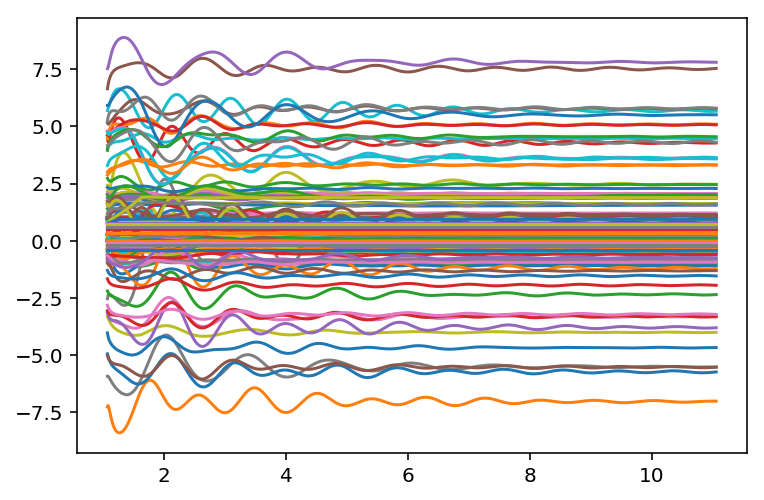

In [85]:
np_preprocessed = load_numpy(os.path.join('/output/', '02_preprocessed_numpy'), '10014.pkl')
# df_preprocessed = pd.read_csv(os.path.join('/data/Data',simulation_files_dict[10002]), header = [0,1])
# df_preprocessed = convert_objects_to_float(df_preprocessed)
# df_preprocessed = add_NSG_columns_and_sort_columns_alphabetically(df_preprocessed)
# df_preprocessed = remove_disturbance(df_preprocessed)
# df_preprocessed = keep_fixed_time_data(df_preprocessed, 10.0)
# df_preprocessed = interpolation_reconstruction_delta_T(df_preprocessed, 0.01)
pyplot.plot(np_preprocessed[:,0],np_preprocessed[:,1:260])

In [79]:
np_preprocessed.shape[1]

260

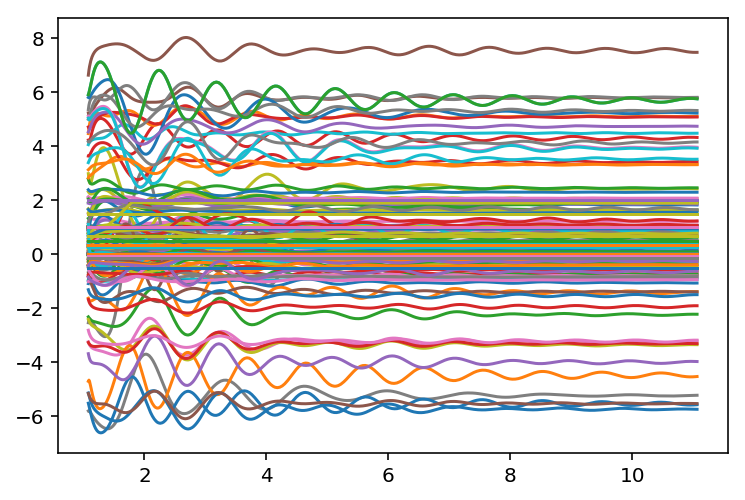

In [0]:
np.abs(df_preprocessed.to_numpy()).max(axis=0)[239]

In [0]:
df_preprocessed.columns.to_list()

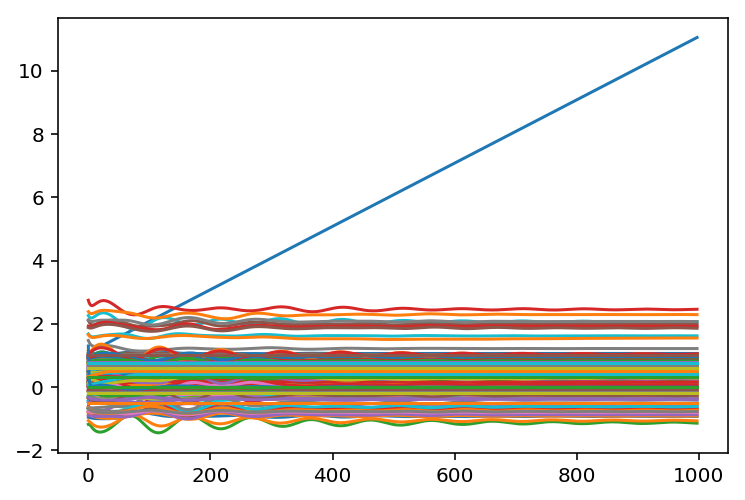

In [14]:
df_preprocessed.plot(legend = False)